<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/fuzzy%20kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Theory k-NN

The k-Nearest Neighbors (kNN) algorithm is a simple, non-parametric, supervised machine learning algorithm used for both classification and regression tasks.
Its core principle is based on the idea that similar data points are likely to have similar outcomes.

How kNN Works (Conceptual Steps):
1.  **Training:** The algorithm stores the entire training dataset. No explicit model fitting occurs during training.
2.  **Prediction (for a new data point):**
    a.  **Distance Calculation:** It calculates the distance between the new data point and every point in the training set.
    b.  **Neighbor Selection:** It identifies the 'k' training points that are closest to the new data point based on the calculated distances.
    c.  **Voting/Averaging:**
        -   For **Classification:** The most frequent class label among the k neighbors is assigned to the new data point (mode).
        -   For **Regression:** The average (or weighted average) of the target values of the k neighbors is used as the prediction.

Distance Metrics Implemented:
1.  **Euclidean Distance (Minkowski p=2):**
    -   Formula: sqrt(sum((x_i - y_i)^2)) or (sum(abs(x_i - y_i)^p))^(1/p) where p=2.
    -   Intuitively, this is the straight-line distance between two points in Euclidean space.
    -   It is sensitive to the scale of the features, which is why standardization is often performed.

2.  **Manhattan Distance (Minkowski p=1):**
    -   Formula: sum(abs(x_i - y_i)).
    -   Also known as City Block or Taxicab distance.
    -   It measures the distance along axes at right angles.
    -   Less sensitive to outliers compared to Euclidean distance.

3.  **Kullback-Leibler (KL) Divergence:**
    -   Formula: sum(P(x) * log(P(x) / Q(x))), where P and Q are probability distributions.
    -   It measures how one probability distribution P diverges from a second expected distribution Q.
    -   It is **asymmetric** (KL(P||Q) != KL(Q||P)).
    -   It is only defined when Q(x) > 0 for all x where P(x) > 0.
    -   To use it with kNN, the feature vectors (rows in the dataset) were normalized using L1 normalization (sum to 1) to treat them as probability distributions.
    -   This is an unconventional use of KL divergence for distance in kNN and assumes the feature vector represents a distribution.


In [1]:
#load libraries and def function

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import seaborn as sns
from sklearn import neighbors # Import for the classifier
from matplotlib.colors import ListedColormap # Import for color maps


--- Fuzzy kNN Classifier Conceptual Visualization ---
Plotting a conceptual example of how fuzzy kNN assigns class memberships based on distance.
Final fuzzy memberships for new point [3.5 4. ]:
  Class 0 (Red): 0.602
  Class 1 (Blue): 0.000
  Class 2 (Green): 0.398


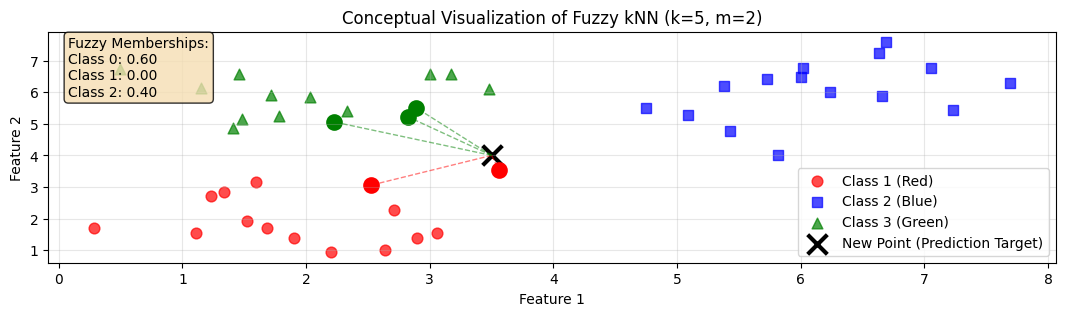

In [2]:

# --- Fuzzy kNN Classifier Conceptual Visualization ---
print("\n--- Fuzzy kNN Classifier Conceptual Visualization ---")
print("Plotting a conceptual example of how fuzzy kNN assigns class memberships based on distance.")

# Generate example 2D data points for a classification task (3 classes)
np.random.seed(123) # For reproducibility
n_class_1 = 15
n_class_2 = 15
n_class_3 = 15
total_points = n_class_1 + n_class_2 + n_class_3

# Class 1 points (red)
X_class1 = np.random.multivariate_normal([2, 2], [[0.5, 0], [0, 0.5]], n_class_1)
y_class1 = np.full(n_class_1, 0) # Label 0 for class 1

# Class 2 points (blue)
X_class2 = np.random.multivariate_normal([6, 6], [[0.5, 0], [0, 0.5]], n_class_2)
y_class2 = np.full(n_class_2, 1) # Label 1 for class 2

# Class 3 points (green)
X_class3 = np.random.multivariate_normal([2, 6], [[0.5, 0], [0, 0.5]], n_class_3)
y_class3 = np.full(n_class_3, 2) # Label 2 for class 3

# Combine data
X_fuzzy = np.vstack([X_class1, X_class2, X_class3])
y_fuzzy = np.hstack([y_class1, y_class2, y_class3])

# Define a new point for prediction (close to all three classes, but slightly closer to class 1)
new_point_fuzzy = np.array([3.5, 4.0])

# Find K nearest neighbors (K=5 for this example)
K_fuzzy = 5
distances_fuzzy = np.linalg.norm(X_fuzzy - new_point_fuzzy, axis=1)
nearest_ids_fuzzy = distances_fuzzy.argsort()[:K_fuzzy]
nearest_points_fuzzy = X_fuzzy[nearest_ids_fuzzy]
nearest_classes_fuzzy = y_fuzzy[nearest_ids_fuzzy]
nearest_distances_fuzzy = distances_fuzzy[nearest_ids_fuzzy]

# Calculate fuzzy memberships for the neighbors (m=2)
fuzzy_m = 2
neighbor_memberships = []
for dist in nearest_distances_fuzzy:
    if dist == 0:
        neighbor_memberships.append(0) # Handle case where distance is 0
    else:
        neighbor_memberships.append(dist**(-1/(fuzzy_m-1)))

# Sum memberships for each class
class_membership_sums = np.zeros(3) # Assuming 3 classes (0, 1, 2)
for i, class_label in enumerate(nearest_classes_fuzzy):
    class_membership_sums[class_label] += neighbor_memberships[i]

# Normalize to get final class memberships (probabilities)
total_membership = np.sum(class_membership_sums)
if total_membership > 0:
    final_class_memberships = class_membership_sums / total_membership
else:
    final_class_memberships = np.zeros(3) # Handle case where all distances are 0

print(f"Final fuzzy memberships for new point {new_point_fuzzy}:")
print(f"  Class 0 (Red): {final_class_memberships[0]:.3f}")
print(f"  Class 1 (Blue): {final_class_memberships[1]:.3f}")
print(f"  Class 2 (Green): {final_class_memberships[2]:.3f}")

# Define color mapping for matplotlib format strings
color_map = {0: 'r', 1: 'b', 2: 'g'} # Maps class label to single-letter color code
color_full = {0: 'red', 1: 'blue', 2: 'green'} # Maps class label to full color name for scatter

# Plot the fuzzy kNN concept
plt.figure(figsize=(13, 3))

# Plot training points by class
plt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', marker='o', s=60, label='Class 1 (Red)', alpha=0.7)
plt.scatter(X_class2[:, 0], X_class2[:, 1], c='blue', marker='s', s=60, label='Class 2 (Blue)', alpha=0.7)
plt.scatter(X_class3[:, 0], X_class3[:, 1], c='green', marker='^', s=60, label='Class 3 (Green)', alpha=0.7)

# Plot the new point
plt.scatter(new_point_fuzzy[0], new_point_fuzzy[1], c='black', marker='x', s=200, linewidths=3, label='New Point (Prediction Target)')

# Highlight the K nearest neighbors and draw lines
for i, neighbor in enumerate(nearest_points_fuzzy):
    class_label = nearest_classes_fuzzy[i]
    color_short = color_map[class_label]
    color_full_name = color_full[class_label]
    # Use the single-letter color code for the line format string
    plt.plot([new_point_fuzzy[0], neighbor[0]], [new_point_fuzzy[1], neighbor[1]], f'{color_short}--', alpha=0.5, linewidth=1)
    # Use the full color name for the scatter plot
    plt.scatter(neighbor[0], neighbor[1], c=color_full_name, s=100, facecolors='none', edgecolors=color_full_name, linewidth=2)

# Add text box with memberships
membership_text = f'Fuzzy Memberships:\nClass 0: {final_class_memberships[0]:.2f}\nClass 1: {final_class_memberships[1]:.2f}\nClass 2: {final_class_memberships[2]:.2f}'
plt.text(0.02, 0.98, membership_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.title(f'Conceptual Visualization of Fuzzy kNN (k={K_fuzzy}, m={fuzzy_m})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# calculate the Minkowski distance (when p=2 we can apply the Euclidean distance) --> use p=2 for KNNreg, FKNNreg
def minkowski_distance(a, b, p):
    return sum(abs(e1-e2)**p for e1, e2 in zip(a,b))**(1/p)

# Manhattan distance (special case of Minkowski with p=1)
def manhattan_distance(a, b):
    return sum(abs(e1-e2) for e1, e2 in zip(a,b))

# Kullback-Leibler divergence (asymmetric)
# P and Q must be probability distributions (non-negative, sum to 1)
def kl_divergence(P, Q):
    # Add a small epsilon to avoid log(0) or division by zero
    epsilon = 1e-10
    P_safe = np.asarray(P) + epsilon
    Q_safe = np.asarray(Q) + epsilon
    # KL divergence is sum(P * log(P / Q))
    # Note: This is KL(P || Q)
    kl_sum = np.sum(P_safe * np.log(P_safe / Q_safe))
    return kl_sum

# find the most similar neighbors
def get_neighbors(xtrain, ytrain, test_sample, K, p, distance_metric='minkowski'):
    distances = list()
    for t in range(len(xtrain)):
        if distance_metric == 'minkowski':
            dist = minkowski_distance(test_sample, xtrain[t], p)
        elif distance_metric == 'manhattan':
            dist = manhattan_distance(test_sample, xtrain[t])
        elif distance_metric == 'kl_divergence':
            # Calculate KL divergence: D(P||Q) where P is test_sample, Q is xtrain[t]
            # Assuming data is already normalized per row for KL
            dist = kl_divergence(test_sample, xtrain[t])
        else:
            raise ValueError(f"Unknown distance metric: {distance_metric}")
        distances.append((ytrain[t], dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(K):
        neighbors.append(distances[i]) # neighbors[0]=y values of neighbors, neighbors[1]=distances
    return neighbors

# calculate fuzzy memberships for the neighbors
def get_memberships(neighbors):
    m = 2
    memberships = list()
    for neighbor in neighbors:
        if neighbor[1] == 0:
            memberships.append(0)
        else:
            memberships.append(neighbor[1]**(-1/(m-1)))
    return(memberships)

# calculate fuzzy weighted average of the outputs of the nearest neighbors (i.e., prediction)
def get_prediction(memberships, neighbors):
    train_y = list()
    for neighbor in neighbors:
        train_y.append(neighbor[0])
    products      = [a * b for a, b in zip(memberships, train_y)]
    if sum(memberships) == 0:
         # If all memberships are zero (e.g., all neighbors are at distance 0),
         # return the mean of the neighbor y values
         return np.mean(train_y)
    predicted_val = sum(products)/sum(memberships)
    return predicted_val

# Functions for the nearest neighbor regression methods
def Md_FKNNreg(xtrain, ytrain, xtest, K, p):
    yhat_mdfknn = list()
    for test_sample in xtest:
        mdfknn_neighbors  = get_neighbors(xtrain, ytrain, test_sample, K, p, distance_metric='minkowski')
        mem_mdfknn        = get_memberships(mdfknn_neighbors)
        mdfknn_prediction = get_prediction(mem_mdfknn, mdfknn_neighbors)
        yhat_mdfknn.append(mdfknn_prediction)
    return yhat_mdfknn

def FKNNreg(xtrain, ytrain, xtest, K, p=2):
    yhat_fknn = list()
    for test_sample in xtest:
        fknn_neighbors   = get_neighbors(xtrain, ytrain, test_sample, K, p, distance_metric='minkowski')
        fknn_memberships = get_memberships(fknn_neighbors)
        fknn_preidiction = get_prediction(fknn_memberships,fknn_neighbors)
        yhat_fknn.append(fknn_preidiction)
    return yhat_fknn

def KNNreg(xtrain, ytrain, xtest, K, p=2):
    yhat_knn = list()
    for test_sample in xtest:
        knn_neighbors      = get_neighbors(xtrain, ytrain, test_sample, K, p, distance_metric='minkowski')
        knn_memberships    = np.ones(K)
        knn_preidiction    = get_prediction(knn_memberships,knn_neighbors)
        yhat_knn.append(knn_preidiction)
    return yhat_knn

def KNNreg_Manhattan(xtrain, ytrain, xtest, K):
    yhat_knn_man = list()
    for test_sample in xtest:
        knn_neighbors      = get_neighbors(xtrain, ytrain, test_sample, K, p=1, distance_metric='manhattan') # p is ignored for manhattan
        knn_memberships    = np.ones(K)
        knn_preidiction    = get_prediction(knn_memberships,knn_neighbors)
        yhat_knn_man.append(knn_preidiction)
    return yhat_knn_man

# This assumes the input data (xtrain, xtest) is normalized per row to represent probability distributions
def KNNreg_KL(xtrain, ytrain, xtest, K):
    yhat_knn_kl = list()
    for test_sample in xtest:
        knn_neighbors      = get_neighbors(xtrain, ytrain, test_sample, K, p=None, distance_metric='kl_divergence') # p is not used for KL
        knn_memberships    = np.ones(K)
        knn_preidiction    = get_prediction(knn_memberships,knn_neighbors)
        yhat_knn_kl.append(knn_preidiction)
    return yhat_knn_kl


# Data Loading and Preprocessing

--- Initial Task Visualization ---
Dataset Shape: (1030, 10)

Dataset Head:
   Cement  Blast  FlyAsh  Water  Superplasticizer  Coarse   Fine  Age  \
0   230.0    0.0   118.3  195.5               4.6  1029.4  758.6    3   
1   116.0  173.0     0.0  192.0               0.0   909.8  891.9    7   
2   255.0    0.0     0.0  192.0               0.0   889.8  945.0    7   
3   238.1    0.0     0.0  185.7               0.0  1118.8  789.3    7   
4   122.6  183.9     0.0  203.5               0.0   958.2  800.1    7   

   Strength  Type  
0     10.03     1  
1     10.09     1  
2     10.22     1  
3     10.34     1  
4     10.35     1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cement            1030 non-null   float64
 1   Blast             1030 non-null   float64
 2   FlyAsh            1030 non-null   float64
 3   Wat

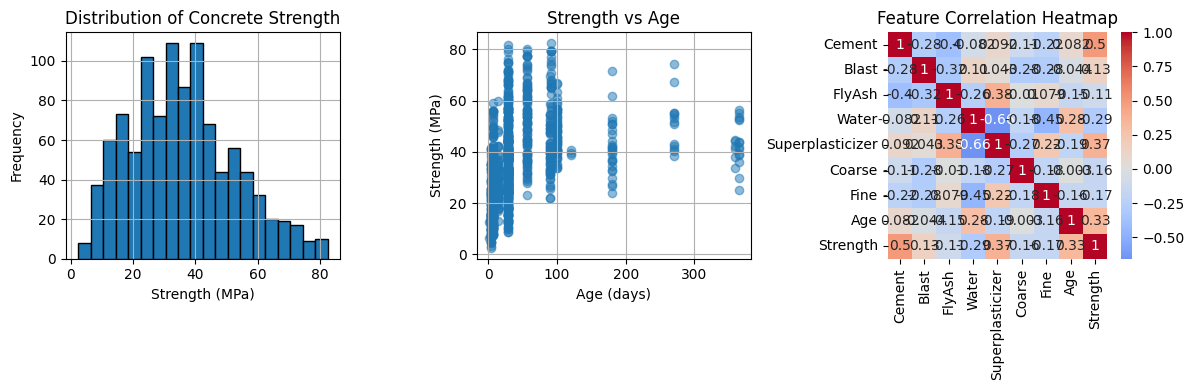

In [4]:
# Import data
url = 'https://raw.githubusercontent.com/TAUforPython/fuzzy/main/ConcreteData.csv'
data = pd.read_csv(url, sep=';')

# Store original Strength for binning later
original_strength = data['Strength'].values

# Prepare features (X) and target (y) - Exclude 'Type' if it's categorical for regression
X_orig = data.drop(['Strength', 'Type'], axis=1).values
y_orig = data['Strength'].values

# --- Initial Task Visualization ---
print("--- Initial Task Visualization ---")
print("Dataset Shape:", data.shape)
print("\nDataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nTarget Variable (Strength) Statistics:")
print(data['Strength'].describe())

# Plot 1: Distribution of Target Variable (Strength)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
data['Strength'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Concrete Strength')
plt.xlabel('Strength (MPa)')
plt.ylabel('Frequency')

# Plot 2: Strength vs Age (common relationship)
plt.subplot(1, 3, 2)
plt.scatter(data['Age'], data['Strength'], alpha=0.5)
plt.title('Strength vs Age')
plt.xlabel('Age (days)')
plt.ylabel('Strength (MPa)')
plt.grid(True)

# Plot 3: Correlation Heatmap (excluding Type)
plt.subplot(1, 3, 3)
# Calculate correlation matrix for numeric columns only
corr_matrix = data.select_dtypes(include=[np.number]).drop(columns=['Type']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

#  Prepare Data for Models

In [5]:
# Standardize features (X) - This is typically done for kNN
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_orig)

# Standardize target (y)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_orig.reshape(-1, 1)).ravel()

# Split the standardized data
xtrain, xtest, ytrain, ytest = train_test_split(X_scaled, y_scaled, test_size=0.20, random_state=42)

# --- Prepare Data for KL Divergence Models ---
# Normalize each row of X_orig to sum to 1 (convert to probability distribution)
X_prob = normalize(X_orig, norm='l1', axis=1) # Use original X, normalize rows
X_prob_train, X_prob_test, _, _ = train_test_split(X_prob, y_orig, test_size=0.20, random_state=42) # Use original y for splitting, but prob X for model
_, _, y_orig_train, y_orig_test = train_test_split(X_orig, y_orig, test_size=0.20, random_state=42) # Align y with prob X splits

# --- Model Execution ---
K = 10

# Run the regression methods (using standardized data for most)
yhat_mdfknn = Md_FKNNreg(xtrain, ytrain, xtest, K, p=2)
yhat_fknn = FKNNreg(xtrain, ytrain, xtest, K)
yhat_knn = KNNreg(xtrain, ytrain, xtest, K)

# Run the new regression methods
yhat_knn_man = KNNreg_Manhattan(xtrain, ytrain, xtest, K)
yhat_knn_kl = KNNreg_KL(X_prob_train, y_orig_train, X_prob_test, K) # Use probability data for KL

# --- Accuracy Measures ---
# Define a function to calculate metrics on scaled predictions vs scaled true values
def calculate_metrics(y_true_scaled, y_pred_scaled):
    mse = mean_squared_error(y_true_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_scaled, y_pred_scaled)
    return mse, rmse, r2

# Calculate metrics for all models (predictions need to be on the same scale as ytest)
# FKNN, MdFKNN, KNN_Euc, KNN_Man predictions are on the scaled scale (yhat_*)
# KNN_KL prediction is on the original scale (yhat_knn_kl), needs scaling
yhat_knn_kl_scaled = scaler_y.transform(np.array(yhat_knn_kl).reshape(-1, 1)).ravel()

mse_f1, rmse_f1, r2_f1 = calculate_metrics(ytest, yhat_mdfknn)
mse_f2, rmse_f2, r2_f2 = calculate_metrics(ytest, yhat_fknn)
mse_f3, rmse_f3, r2_f3 = calculate_metrics(ytest, yhat_knn)
mse_man, rmse_man, r2_man = calculate_metrics(ytest, yhat_knn_man)
mse_kl, rmse_kl, r2_kl = calculate_metrics(ytest, yhat_knn_kl_scaled) # Use scaled prediction

# Print results
print("\n--- Model Comparison (Scaled Target) ---")
results_df = pd.DataFrame({
    'Model': ['Md-FKNNreg', 'FKNNreg', 'KNNreg (Euc)', 'KNNreg (Man)', 'KNNreg (KL)'],
    'MSE': [mse_f1, mse_f2, mse_f3, mse_man, mse_kl],
    'RMSE': [rmse_f1, rmse_f2, rmse_f3, rmse_man, rmse_kl],
    'R2': [r2_f1, r2_f2, r2_f3, r2_man, r2_kl]
})
print(results_df)


--- Model Comparison (Scaled Target) ---
          Model       MSE      RMSE        R2
0    Md-FKNNreg  0.292389  0.540730  0.730157
1       FKNNreg  0.292389  0.540730  0.730157
2  KNNreg (Euc)  0.350510  0.592039  0.676517
3  KNNreg (Man)  0.339489  0.582657  0.686688
4   KNNreg (KL)  0.206258  0.454156  0.809646


#  Visualizations

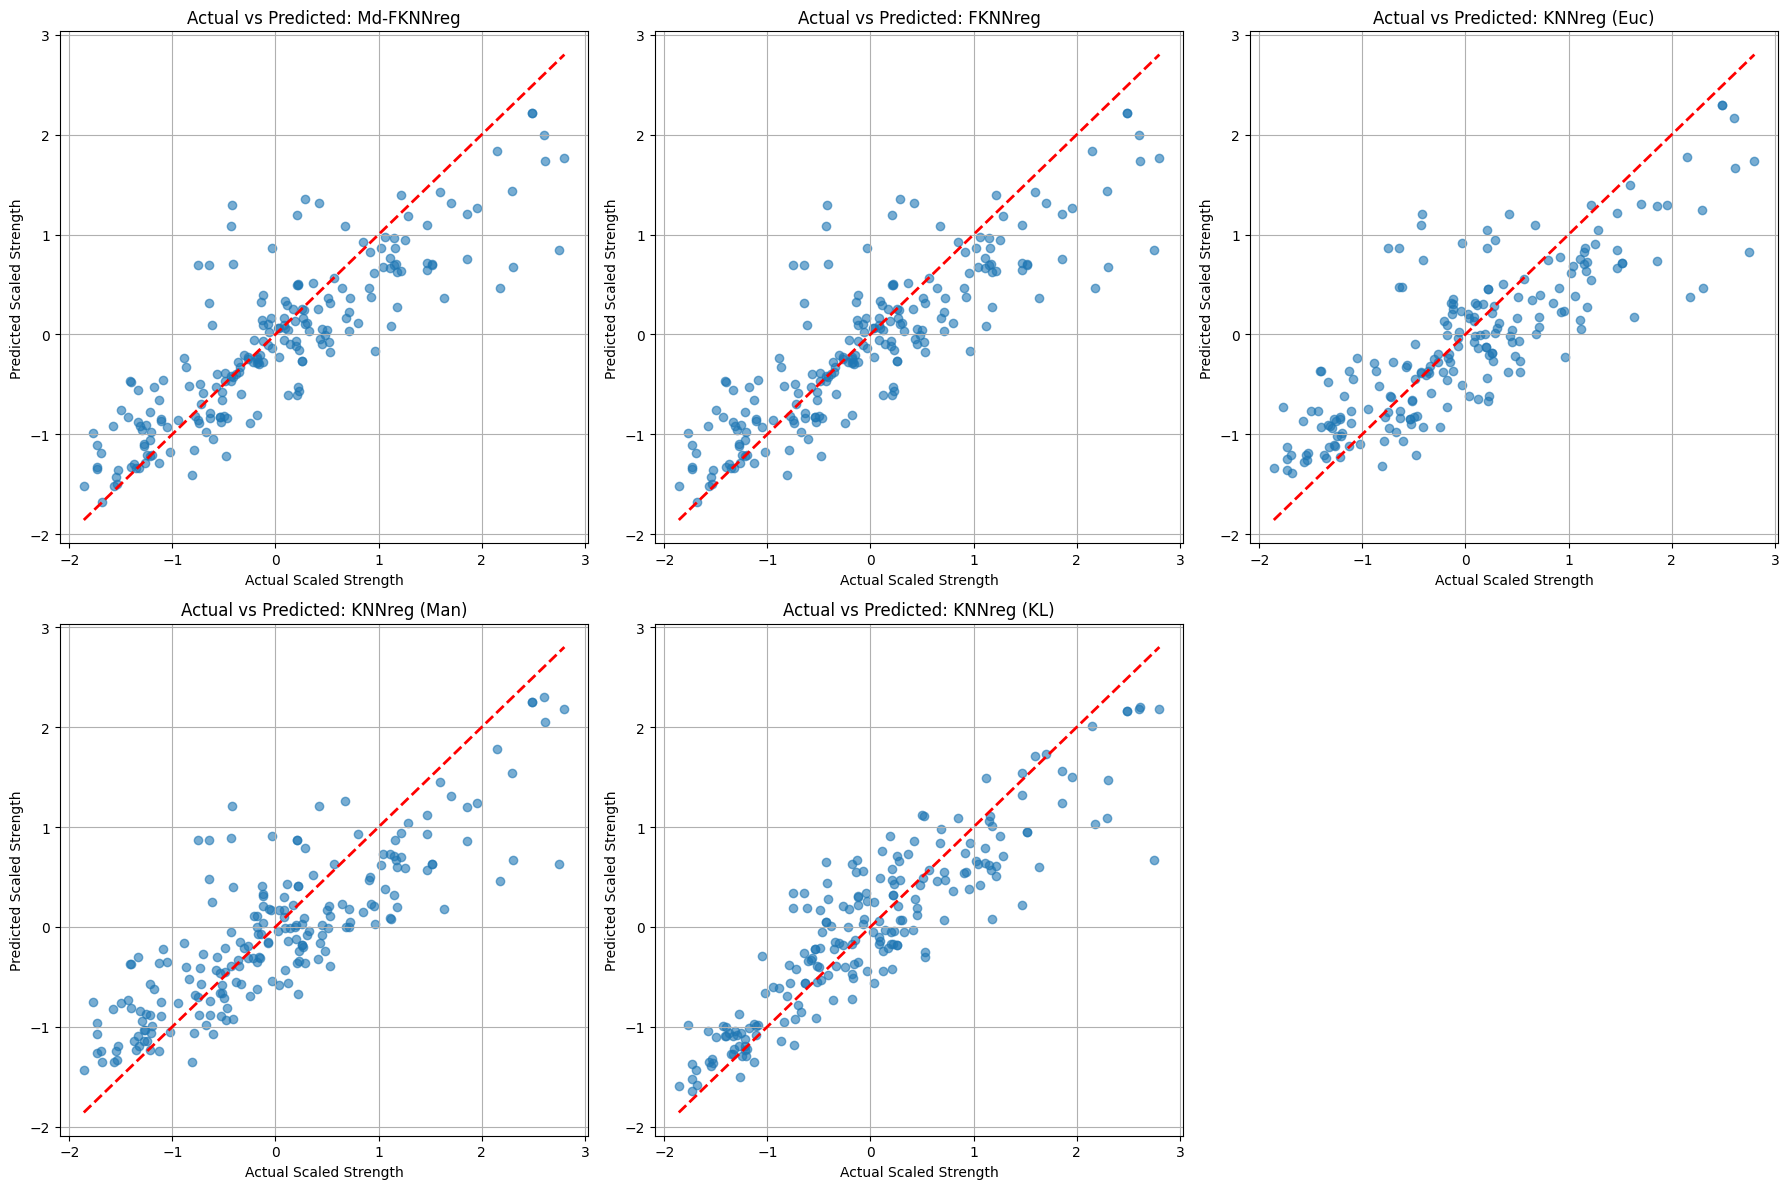

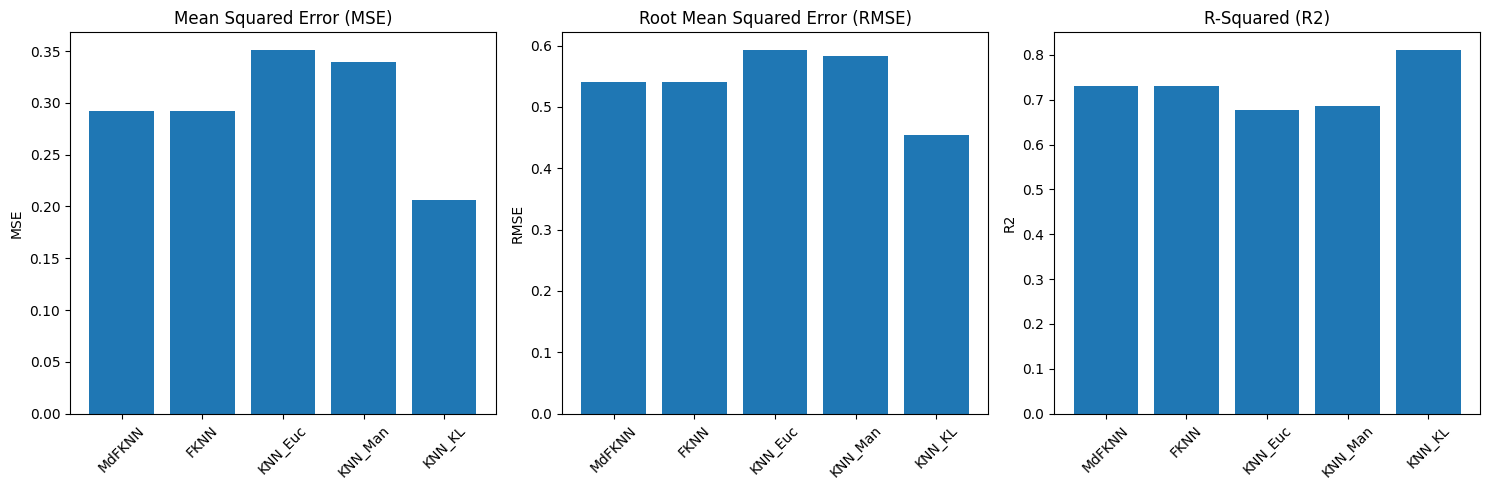

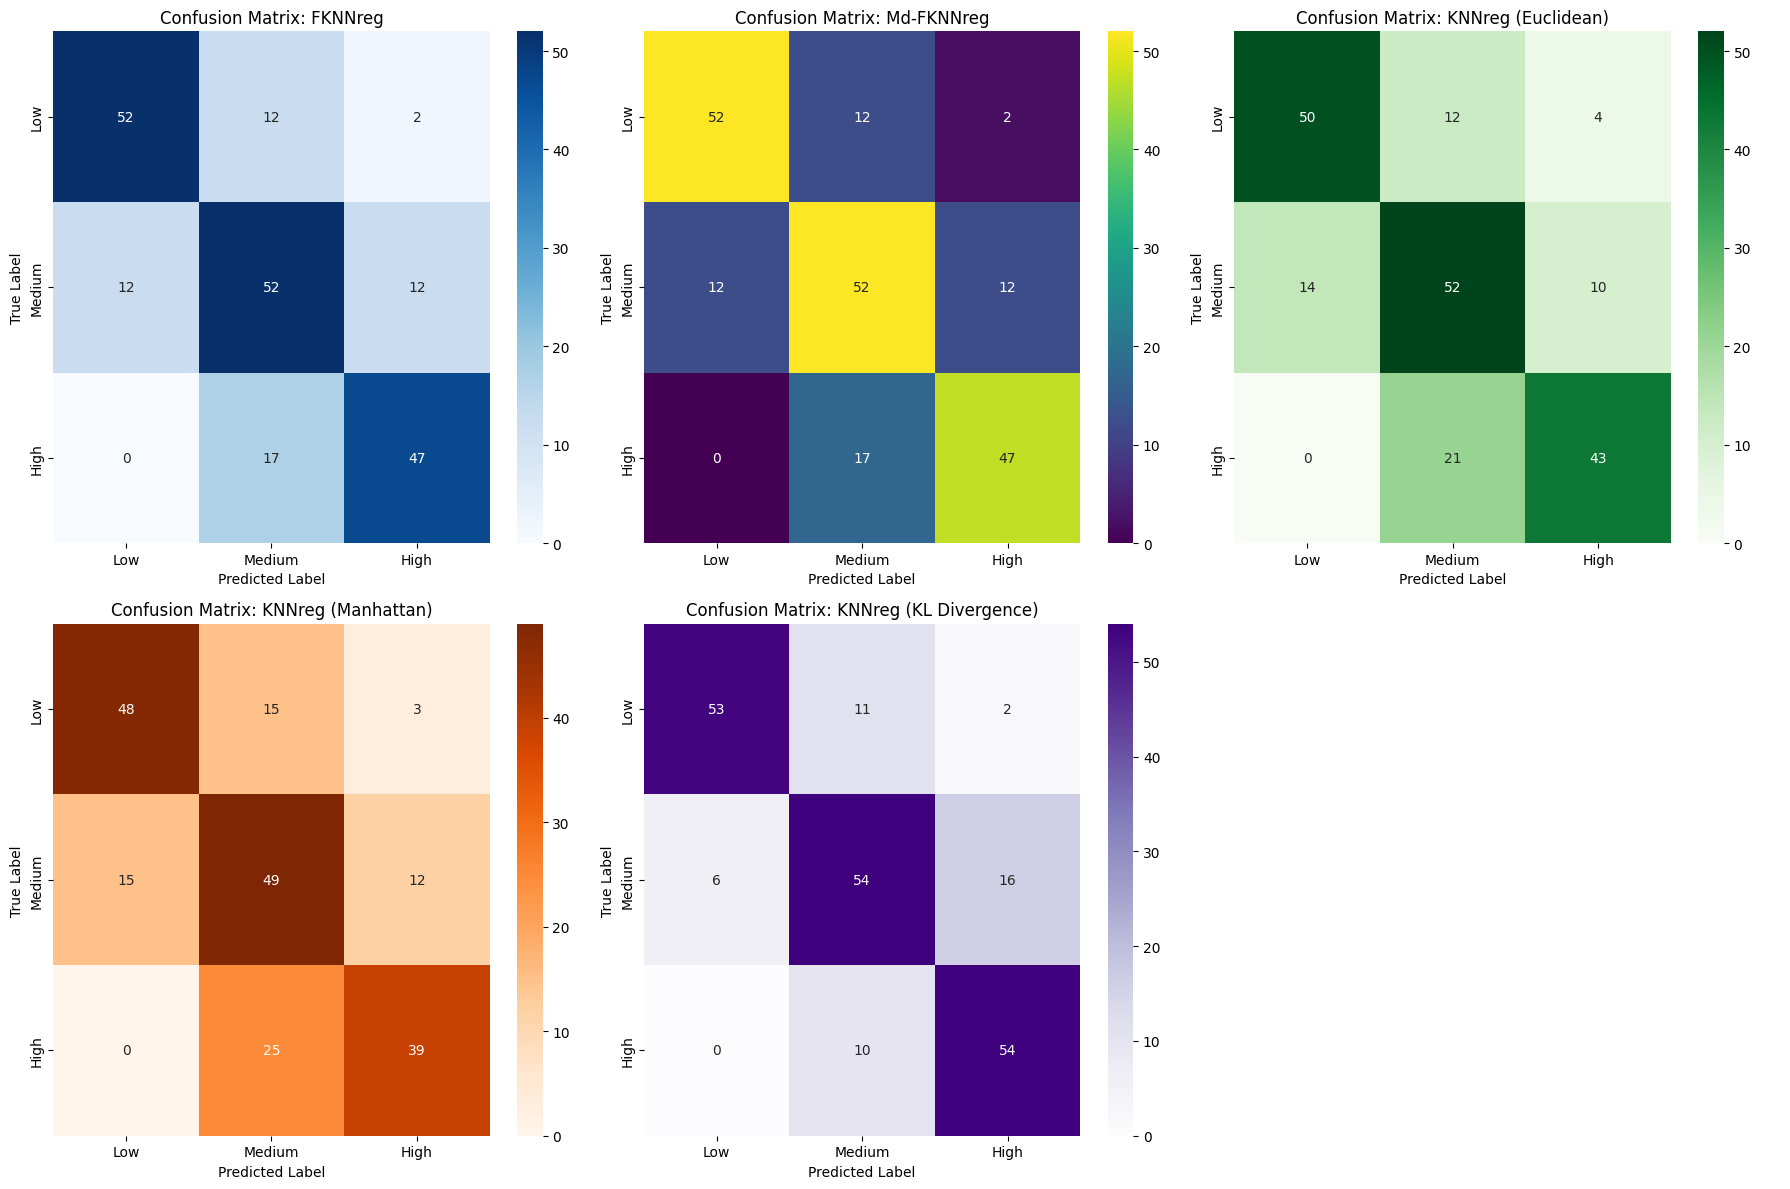

In [6]:

# 1. Actual vs Predicted Scatter Plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel() # Flatten for easy iteration

model_preds = [
    (yhat_mdfknn, 'Md-FKNNreg'),
    (yhat_fknn, 'FKNNreg'),
    (yhat_knn, 'KNNreg (Euc)'),
    (yhat_knn_man, 'KNNreg (Man)'),
    (yhat_knn_kl_scaled, 'KNNreg (KL)') # Use scaled prediction for consistency on y-axis
]
# Add an empty subplot
axes[5].axis('off')

for i, (preds, title) in enumerate(model_preds):
    axes[i].scatter(ytest, preds, alpha=0.6)
    axes[i].plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Scaled Strength')
    axes[i].set_ylabel('Predicted Scaled Strength')
    axes[i].set_title(f'Actual vs Predicted: {title}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# 2. Bar Chart of Metrics
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

models = ['MdFKNN', 'FKNN', 'KNN_Euc', 'KNN_Man', 'KNN_KL']
mse_values = [mse_f1, mse_f2, mse_f3, mse_man, mse_kl]
rmse_values = [rmse_f1, rmse_f2, rmse_f3, rmse_man, rmse_kl]
r2_values = [r2_f1, r2_f2, r2_f3, r2_man, r2_kl]

ax[0].bar(models, mse_values)
ax[0].set_title('Mean Squared Error (MSE)')
ax[0].set_ylabel('MSE')
plt.setp(ax[0].get_xticklabels(), rotation=45)

ax[1].bar(models, rmse_values)
ax[1].set_title('Root Mean Squared Error (RMSE)')
ax[1].set_ylabel('RMSE')
plt.setp(ax[1].get_xticklabels(), rotation=45)

ax[2].bar(models, r2_values)
ax[2].set_title('R-Squared (R2)')
ax[2].set_ylabel('R2')
plt.setp(ax[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 3. Confusion Matrices for Binned Strength (using original scale for binning thresholds)
# Determine bin edges based on the ORIGINAL (unscaled) strength values
p33 = np.percentile(original_strength, 33)
p66 = np.percentile(original_strength, 66)
strength_bins = [-np.inf, p33, p66, np.inf]
strength_labels = ['Low', 'Medium', 'High']

# Binarize the true test labels (from original split)
ytest_binned = np.digitize(y_orig_test, strength_bins, right=False) - 1
ytest_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in ytest_binned]

# Binarize predictions
# FKNN, MdFKNN, KNN_Euc, KNN_Man predictions are on scaled scale, need inverse transform
yhat_fknn_orig = scaler_y.inverse_transform(np.array(yhat_fknn).reshape(-1, 1)).ravel()
yhat_mdfknn_orig = scaler_y.inverse_transform(np.array(yhat_mdfknn).reshape(-1, 1)).ravel()
yhat_knn_orig = scaler_y.inverse_transform(np.array(yhat_knn).reshape(-1, 1)).ravel()
yhat_knn_man_orig = scaler_y.inverse_transform(np.array(yhat_knn_man).reshape(-1, 1)).ravel()
# KNN_KL prediction is already on original scale (yhat_knn_kl)

yhat_fknn_binned = np.digitize(yhat_fknn_orig, strength_bins, right=False) - 1
yhat_fknn_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_fknn_binned]

yhat_mdfknn_binned = np.digitize(yhat_mdfknn_orig, strength_bins, right=False) - 1
yhat_mdfknn_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_mdfknn_binned]

yhat_knn_binned = np.digitize(yhat_knn_orig, strength_bins, right=False) - 1
yhat_knn_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_knn_binned]

yhat_knn_man_binned = np.digitize(yhat_knn_man_orig, strength_bins, right=False) - 1
yhat_knn_man_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_knn_man_binned]

yhat_knn_kl_binned = np.digitize(yhat_knn_kl, strength_bins, right=False) - 1
yhat_knn_kl_binned_labels = [strength_labels[i] if i < len(strength_labels) else strength_labels[-1] for i in yhat_knn_kl_binned]

# Plot Confusion Matrices
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

cm_list = [
    (confusion_matrix(ytest_binned_labels, yhat_fknn_binned_labels, labels=strength_labels), 'FKNNreg'),
    (confusion_matrix(ytest_binned_labels, yhat_mdfknn_binned_labels, labels=strength_labels), 'Md-FKNNreg'),
    (confusion_matrix(ytest_binned_labels, yhat_knn_binned_labels, labels=strength_labels), 'KNNreg (Euclidean)'),
    (confusion_matrix(ytest_binned_labels, yhat_knn_man_binned_labels, labels=strength_labels), 'KNNreg (Manhattan)'),
    (confusion_matrix(ytest_binned_labels, yhat_knn_kl_binned_labels, labels=strength_labels), 'KNNreg (KL Divergence)'),
]

for i, (cm, title) in enumerate(cm_list):
    row = i // 3
    col = i % 3
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if i == 0 else 'viridis' if i == 1 else 'Greens' if i == 2 else 'Oranges' if i == 3 else 'Purples',
                xticklabels=strength_labels, yticklabels=strength_labels, ax=ax[row, col])
    ax[row, col].set_title(f'Confusion Matrix: {title}')
    ax[row, col].set_ylabel('True Label')
    ax[row, col].set_xlabel('Predicted Label')

# Add an empty subplot
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()




--- Fuzzy kNN Classification Decision Boundary Visualization ---
Plotting fuzzy kNN classifier decision boundaries and uncertainty.


/tmp/ipython-input-1779110209.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_uncertainty = plt.cm.get_cmap('viridis_r', 256) # Colormap for uncertainty (e.g., difference between top 2 memberships)


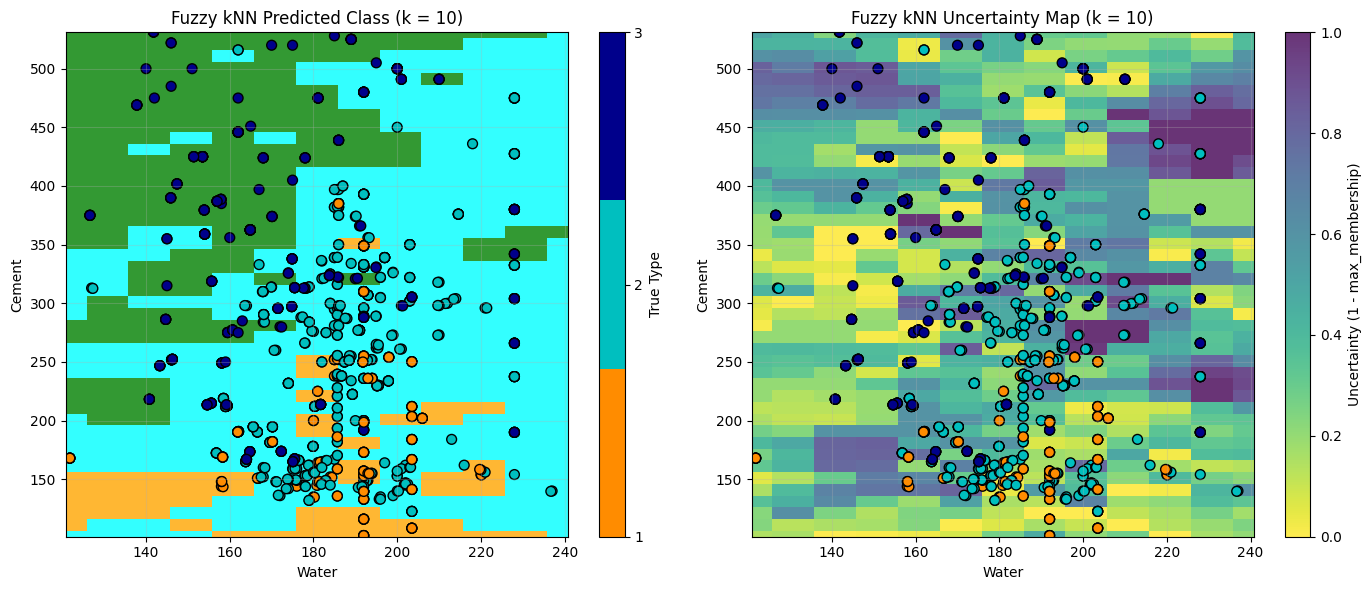

In [7]:

# --- Fuzzy kNN Classification Decision Boundary Visualization ---
print("\n--- Fuzzy kNN Classification Decision Boundary Visualization ---")
print("Plotting fuzzy kNN classifier decision boundaries and uncertainty.")

# Use the same data as the standard kNN visualization (Water vs. Cement, Type)
# Prepare data for classification visualization (using original, unscaled data)
# Select features for visualization: Water (index 3) and Cement (index 0)
XX_fuzzy_class = [data['Water'], data['Cement']]
yy_fuzzy_class = data['Type']

X_fuzzy_class = np.transpose(np.array(list(XX_fuzzy_class)))
y_fuzzy_class = np.transpose(np.array(list(yy_fuzzy_class)))

# Define classifier parameters for fuzzy kNN logic
k_fuzzy_class = 10
# Note: This is a conceptual implementation of fuzzy kNN logic, not a direct sklearn call
# We will manually implement the prediction logic for the mesh grid

# Define color maps for visualization
cmap_light = ListedColormap(['orange', 'cyan', 'green']) # Colors for decision regions (hard class prediction)
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue']) # Colors for data points
cmap_uncertainty = plt.cm.get_cmap('viridis_r', 256) # Colormap for uncertainty (e.g., difference between top 2 memberships)

# Create a mesh to plot the decision boundary
h = 10  # Step size in the mesh
x_min, x_max = X_fuzzy_class[:, 0].min() - 1, X_fuzzy_class[:, 0].max() + 1
y_min, y_max = X_fuzzy_class[:, 1].min() - 1, X_fuzzy_class[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_points = np.c_[xx.ravel(), yy.ravel()]

# Function to predict fuzzy memberships for a single point (based on provided functions)
def predict_fuzzy_memberships(point, X_train, y_train, K, m=2):
    # Find neighbors
    distances = np.linalg.norm(X_train - point, axis=1)
    nearest_ids = distances.argsort()[:K]
    nearest_classes = y_train[nearest_ids]
    nearest_distances = distances[nearest_ids]

    # Calculate neighbor memberships
    neighbor_memberships = []
    for dist in nearest_distances:
        if dist == 0:
            neighbor_memberships.append(0)
        else:
            neighbor_memberships.append(dist**(-1/(m-1)))

    # Sum memberships per class
    unique_classes = np.unique(y_train)
    class_membership_sums = np.zeros(len(unique_classes))
    for i, class_label in enumerate(nearest_classes):
        class_idx = np.where(unique_classes == class_label)[0][0]
        class_membership_sums[class_idx] += neighbor_memberships[i]

    # Normalize
    total_membership = np.sum(class_membership_sums)
    if total_membership > 0:
        final_memberships = class_membership_sums / total_membership
    else:
        final_memberships = np.zeros(len(unique_classes))
    return unique_classes, final_memberships

# Predict for each point in the mesh
predicted_classes = []
predicted_uncertainties = []
unique_classes_mesh = np.unique(y_fuzzy_class) # [1, 2, 3]

for point in mesh_points:
    classes, memberships = predict_fuzzy_memberships(point, X_fuzzy_class, y_fuzzy_class, k_fuzzy_class, m=2)
    # Find predicted class (highest membership)
    if len(memberships) > 0:
        pred_class_idx = np.argmax(memberships)
        pred_class = classes[pred_class_idx]
        predicted_classes.append(pred_class)
        # Calculate uncertainty (e.g., difference between highest and second highest membership)
        sorted_memberships = np.sort(memberships)[::-1] # Descending order
        if len(sorted_memberships) > 1:
            uncertainty = sorted_memberships[0] - sorted_memberships[1]
        else:
            uncertainty = 1.0 # If only one neighbor, uncertainty is 0 (or 1 - 0), let's say 1 - 0 = 1 is max certainty, so uncertainty = 0. If only one class possible, max certainty -> uncertainty = 0
            # Actually, if only one class is possible in neighbors, the difference is between the highest and zero (if no second exists), so it's just the highest membership.
            # A better measure of uncertainty might be entropy or 1 - max_membership.
            # Let's use 1 - max_membership as a simple measure of uncertainty (0 = certain, 1 = uncertain)
            uncertainty = 1.0 - sorted_memberships[0]
        predicted_uncertainties.append(uncertainty)
    else:
        predicted_classes.append(unique_classes_mesh[0]) # Default if no prediction possible
        predicted_uncertainties.append(1.0) # Max uncertainty

# Reshape results for plotting
Z_class = np.array(predicted_classes).reshape(xx.shape)
Z_uncertainty = np.array(predicted_uncertainties).reshape(xx.shape)

# Plot 1: Predicted Class Decision Boundary
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z_class, cmap=cmap_light, alpha=0.8) # Plot decision regions based on predicted class
scatter = plt.scatter(X_fuzzy_class[:, 0], X_fuzzy_class[:, 1], c=y_fuzzy_class, cmap=cmap_bold, edgecolor='k', s=50) # Plot data points
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(data.columns[3]) # Water
plt.ylabel(data.columns[0]) # Cement
plt.title(f"Fuzzy kNN Predicted Class (k = {k_fuzzy_class})")
plt.colorbar(scatter, ticks=[1, 2, 3], label='True Type')
plt.grid(True, alpha=0.3)

# Plot 2: Uncertainty Map
plt.subplot(1, 2, 2)
im_uncertainty = plt.pcolormesh(xx, yy, Z_uncertainty, cmap=cmap_uncertainty, alpha=0.8, vmin=0, vmax=1) # Plot uncertainty
plt.colorbar(im_uncertainty, label='Uncertainty (1 - max_membership)')
plt.scatter(X_fuzzy_class[:, 0], X_fuzzy_class[:, 1], c=y_fuzzy_class, cmap=cmap_bold, edgecolor='k', s=50) # Overlay data points
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel(data.columns[3]) # Water
plt.ylabel(data.columns[0]) # Cement
plt.title(f"Fuzzy kNN Uncertainty Map (k = {k_fuzzy_class})")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()